In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [51]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [52]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [53]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [54]:
import os

filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preprocessing Data

In [55]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [56]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [57]:
len(train_lines)

210040

* Converting each sentence in the list of dictionary from text file

In [58]:
def preprocess_text_with_line_number(filename):
  """
  returns a list of dictionary of lines data
  
  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
    
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
       abstract_lines += line

  return abstract_samples

In [59]:
# getting data from file and preocess it
train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')

In [60]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [61]:
train_samples[:2]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11}]

* Converting list of dictionaries in pandas dataframe

In [62]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [63]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [64]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


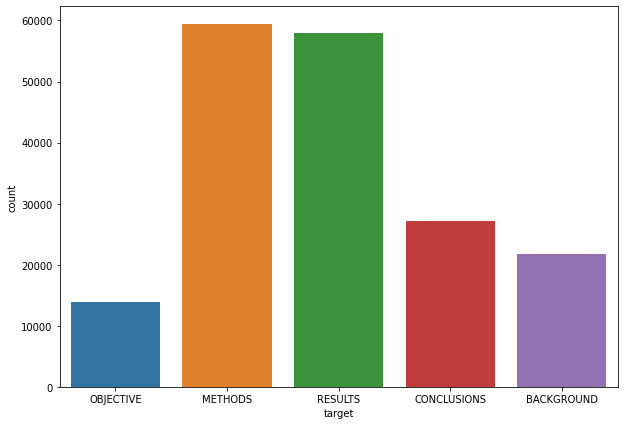

In [65]:
plt.figure(figsize=(10,7))
sns.countplot('target',data=train_df);

# List of sentences

In [18]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

# Making Numeric labels

In [19]:
from sklearn.preprocessing import OneHotEncoder

In [20]:
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
label_encoder = LabelEncoder()

train_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

# class names and number of classes

In [23]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Useful Functions

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accurecy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results

In [25]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2021-10-31 07:54:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-31 07:54:59 (32.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Text vectorizor

In [26]:
from tensorflow.keras.layers import TextVectorization, Embedding

sent_len = round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))
sent_len

26

In [27]:
max_vocab_length = 68000
max_length = 55

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

In [28]:
max_vocab_length = 68000
max_length = 55

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

text_vectorizer.adapt(train_sentences)

# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [29]:
embedding = Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    name='token_embedding'
    
)

# Character level Tokeninzer

In [30]:
def split_character(text):
  return ' '.join(list(text))

In [31]:
train_chars = [split_character(sentences) for sentences in train_sentences]
val_chars = [split_character(sentences) for sentences in val_sentences]
test_chars = [split_character(sentences) for sentences in test_sentences]

In [32]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [33]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKEN = len(alphabet) + 2

char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKEN,
    output_sequence_length = output_seq_char_len,
)

char_vectorizer.adapt(train_chars)

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


## Character level Embedding layer

In [34]:
char_embedding = Embedding(
    input_dim = len(char_vocab),
    output_dim = 25,
    name = 'char_embed'
)

# Positional Embedding Layer

In [35]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)


train_line_number_one_hot[:5], train_line_number_one_hot.shape

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [36]:
train_total_line_number_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_number_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_number_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)


train_total_line_number_one_hot[:5], train_line_number_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>, TensorShape([180040, 15]))

# Creating tribrid inputs

In [37]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_line_number_one_hot, train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [38]:
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_line_number_one_hot, val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot, test_total_line_number_one_hot, test_sentences, test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))

test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Bulding BERT Models

In [40]:
! pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 5.2 MB/s 


In [41]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

In [42]:
preprocess_layer = hub.KerasLayer(preprocess, name='bert_input_preprocess')
bert_layer = hub.KerasLayer(bert, name='bert_layer')

In [43]:
# 1. token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs', ragged=False)
bert_input = preprocess_layer(token_inputs)
bert_outputs = bert_layer(bert_input, training=False)
sequence_output = bert_outputs['pooled_output']
token_outputs = layers.Dense(128, activation='relu')(sequence_output)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Charater imputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input', ragged=False)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. model for line_number feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_numbers_input')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs) 

# 4. model for total_line feature
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

# 5. Concat layer 1 & 2
token_char_concat = layers.Concatenate(name='concat_layer')([token_model.output,
                                                             char_model.output])

# adding one dropout layer
z = layers.Dense(256, activation='relu')(token_char_concat)
z = layers.Dropout(0.5)(z)

# 6. concat layers 3 4 5
final_concat = layers.Concatenate(name='final_concat')([
    line_number_model.output,
    total_lines_model.output,
    z
])

# Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_concat)

# final model
model = tf.keras.Model(
    inputs = [
              line_number_model.input,
              total_lines_model.input,
              token_model.input,
              char_model.input,
    ],
    outputs = output_layer
)

In [44]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
bert_input_preprocess (KerasLay {'input_word_ids': ( 0           token_inputs[0][0]               
__________________________________________________________________________________________________
text_vectorization_2 (TextVecto (None, 290)          0           char_input[0][0]                 
____________________________________________________________________________________________

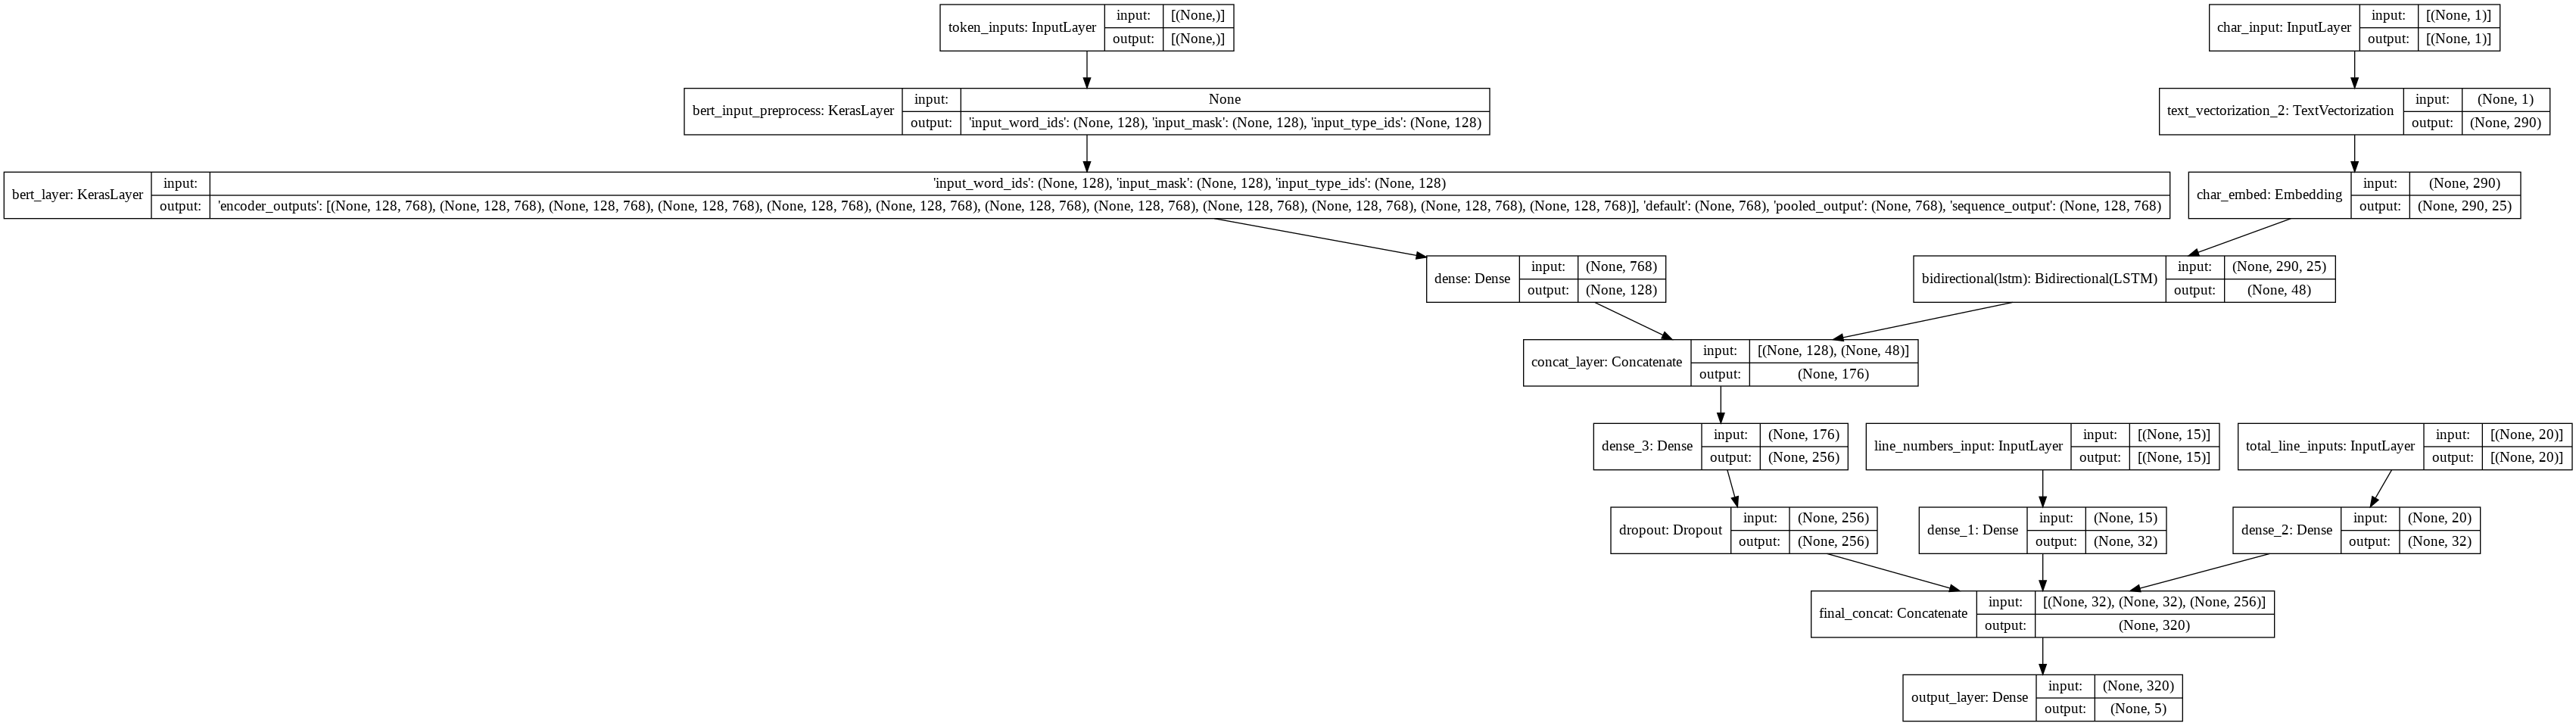

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [46]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = Adam(),
    metrics = ['accuracy'],
)

In [47]:
history = model.fit(
    train_tribrid_dataset,
    epochs = 3,
    steps_per_epoch = len(train_tribrid_dataset),
    validation_data = val_tribrid_dataset,
    validation_steps = int(0.15 * len(val_tribrid_dataset)),
    callbacks = [
      tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2', save_best_only=True),
    ] 
)

Epoch 1/3
5627/5627 [==============================] - 3819s 675ms/step - loss: 0.8855 - accuracy: 0.8697 - val_loss: 0.8628 - val_accuracy: 0.8739


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2/assets


Epoch 2/3
5627/5627 [==============================] - 3782s 672ms/step - loss: 0.8566 - accuracy: 0.8856 - val_loss: 0.8543 - val_accuracy: 0.8834


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2/assets


Epoch 3/3
5627/5627 [==============================] - 3799s 675ms/step - loss: 0.8506 - accuracy: 0.8895 - val_loss: 0.8458 - val_accuracy: 0.8810


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2/assets


## Evaluating model on validation Data

In [66]:
bert_model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2')

In [67]:
bert_model.evaluate(val_tribrid_dataset)

945/945 [==============================] - 787s 832ms/step - loss: 0.8480 - accuracy: 0.8821


[0.8479732871055603, 0.8820998072624207]

## Saving Model

In [68]:
bert_model.save('Skimlit_BertModel')

INFO:tensorflow:Assets written to: Skimlit_BertModel/assets


INFO:tensorflow:Assets written to: Skimlit_BertModel/assets


In [69]:
loaded_model = tf.keras.models.load_model('/content/Skimlit_BertModel')

In [70]:
!zip -r /content/Skimlit_BertModel.zip /content/Skimlit_BertModel

  adding: content/Skimlit_BertModel/ (stored 0%)
  adding: content/Skimlit_BertModel/keras_metadata.pb (deflated 89%)
  adding: content/Skimlit_BertModel/saved_model.pb (deflated 91%)
  adding: content/Skimlit_BertModel/assets/ (stored 0%)
  adding: content/Skimlit_BertModel/assets/vocab.txt (deflated 53%)
  adding: content/Skimlit_BertModel/variables/ (stored 0%)
  adding: content/Skimlit_BertModel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Skimlit_BertModel/variables/variables.index (deflated 79%)


## Testing Model on test data

In [71]:
loaded_model.evaluate(test_tribrid_dataset)

942/942 [==============================] - 793s 840ms/step - loss: 0.8566 - accuracy: 0.8783


[0.8566261529922485, 0.8783474564552307]